# First, you need to import ImagesOriginales.zip and nt_toolbox.zip

# For the sake of simplicity we are gonna analyze only the first image (even thought I made several test with other images)

In [1]:
import zipfile
import os
with zipfile.ZipFile("nt_toolbox.zip","r") as zip_ref:
    zip_ref.extractall(os.getcwd())
from __future__ import division
from nt_toolbox.nt_toolbox.general import *
from nt_toolbox.nt_toolbox.signal import *
%pylab inline
%matplotlib inline
%load_ext autoreload
%autoreload 2
import cv2
import skimage
import matplotlib.pyplot as plt
from pylab import *
import numpy as np
import operator
import pandas as pd
import time
from logging import exception


with zipfile.ZipFile("ImagesOriginales.zip","r") as zip_ref:
    zip_ref.extractall(os.getcwd())

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['pylab']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# Function to compute the TV norm and to inject noise in the image and to normalize in a range [0,1] in case one value of the image is greater than 1

In [70]:
def generateNoise(img, mode,seed,var,clip = False):
    ###
    # img : input image
    # mode : gaussian , poisson, speckle
    # seed : seed for the random generator
    # clip : True or False (clip the output in the range -1 , 1)
    # var : (variance for Gaussian and speckle mode)
    ###

    if mode == 'gaussian' or mode == 'speckle':
        gimg = skimage.util.random_noise(img, mode=mode,seed=seed,clip=clip,var=var)
        return gimg
    if mode == 'poisson':
      gimg = skimage.util.random_noise(img, mode=mode,seed=seed,clip=clip)
      return gimg

def TV_norm(gradX):
  ###
  # gradX : input tensor of shape (m,n,2)
  ###
  sum = 0
  (m,n,k) = np.shape(gradX)
  if(k != 2):
    print("The shape of GradX is not what was expected")
    raise exception
  sum = (np.sqrt(gradX[:,:,0]**2 + gradX[:,:,1]**2)).sum().sum()
  return sum

def zeroOneScaling(img):
  ###
  # img : input image
  ###
  if np.max(img) > 1 or np.min(img) < 0:
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
  return img


# Important consideration about the gradient descent algorithm:

# The usual update for the sequence $x_k$ is:  $x_k = x_k - \tau \cdot \frac{d }{dx}(\frac{1}{2} \left\|x -y\right\|_2 + TV(x))$

# The derivative of the cost function is: $(x-y) -\lambda * div(\frac{Dx}{\left\| Dx \right\|_2})$
#The functions to compute the gradients are from the library nt_toolbox of Gabriel Peyre. While the SSIM is from skimage.

# The value of the step rate is: $\tau = \frac{1.9}{1 + \frac{\lambda \cdot 8}{ϵ}}$

# There is a flag variable called early_stopping if you want the stopping criteria to be active.

#The stopping criteria are:
-----
# $\frac{\left|x_{k} - x_{k-1}\right|}{x_k}$ < 20 * $ϵ$

# $\frac{SSIM(x_{k},img) - SSIM(x_{k-1},img)}{SSIM(x_k,img)} < \epsilon$

#With $\epsilon = 10^{-6}$
------

#If the stopping criteria are met, the value of the last iteration is transpose to all the following iteration. In this way we are gonna have a flat line in the following graphs after the stopped iteration.

In [77]:
def GradientDescent(x0, lmbda, maxiter, y, img, early_stopping = True, stopping_threshold = 10e-6):
  """
  Compute the minima of an optimization problem with a convex cost function

  PARAMETERS
  x0: (nd.array) initial sequence of the corrupted image
  lmbda: parameter of the regularization term
  maxiter: max of iteration of the algorithm
  y: corrupted image
  img: ground truth
  early stopping: True if we want a stopping criteria is active
  stopping_threshold: small value for the stopping criteria


  RETURN
  xk: final sequence of the corrupted image (after the denoising)
  lmbda: parameter of the regularization term
  cost: list of the values regarding the cost function
  err: list of L2 norms of xk - img
  SSIMerr: list of SSIM values between xk and img
  """
  xk = x0
  cost = np.zeros(maxiter)
  err = np.zeros(maxiter)
  SSIMerr = np.zeros(maxiter)
  (n1,n2) = np.shape(y)
  epsilon = 0.4*1e-2
  tau = 1.9 / (1 + lmbda * 8 / epsilon)
  for k in range(0,maxiter):
     repeatN = lambda x,k: resize( repeat( x, k, axis=1), [n1,n2,k])
     Gr = grad(xk) # Dx = (D^h x , D^v x)
     d = sqrt(epsilon**2 + sum(Gr**2, axis=2)) # ||Dx||_2 (with epsilon for smoothness)
     G = -div(Gr / repeatN(d,2) ) # -div (Dx / ||Dx||_2 )
     e = xk -y
     xk = xk - tau*(e + lmbda*G)
     cost[k] = 0.5 * np.linalg.norm(e,2)**2 + lmbda * TV_norm(Gr)
     err[k] = np.linalg.norm(xk - img) #L2 norn
     SSIMerr[k] = skimage.metrics.structural_similarity(xk,img, data_range = 2)
     if early_stopping is True:
      if np.abs(cost[k] - cost[k-1]) / cost[k] < 20*stopping_threshold or (SSIMerr[k] - SSIMerr[k-1]) / SSIMerr[k] < stopping_threshold:
       cost[k:maxiter] = cost[k]
       err[k:maxiter] = err[k]
       SSIMerr[k:maxiter] = SSIMerr[k]
       print(f"I got stopped at iteration {k}")
       break

  return xk, lmbda, cost, err, SSIMerr

# Notice how small $\tau$ (between $10^{-4}$ and $10^{-3}$) is based on the lambda [0.1, ..., 1]

In [66]:
epsilon = 0.4*1e-2
for lmbda in np.arange(0.1,1,0.1):
  print(1.9 / (1 + lmbda * 8 / epsilon))

0.00945273631840796
0.004738154613466334
0.003161397670549084
0.002372034956304619
0.001898101898101898
0.001582014987510408
0.0013561741613133476
0.0011867582760774515
0.0010549694614103275


In [4]:
def plotResults(img , y ,xk , cost, err, SSIMerr, lmbda):
    lmbda = str(lmbda)

    # plot the ground truth, the final acquisition (blurred and noisy) and the reconstruction
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap='gray')
    plt.title('Ground truth')
    plt.subplot(1, 3, 2)
    plt.imshow(y, cmap='gray')
    plt.title('Acquisition')
    plt.subplot(1, 3, 3)
    plt.imshow(xk, cmap='gray')
    plt.title('Reconstruction for lambda = ' + lmbda)
    plt.show()

    # plot how the cost function decreases and how the iterates converge
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(cost)
    plt.xlabel('$k$')
    plt.ylabel("$F(x_k)$")
    plt.title('Cost function')
    plt.subplot(1, 3, 2)
    plt.plot(err)
    plt.xlabel('$k$')
    plt.ylabel("$|x_k - img|_2$")
    plt.title('L2 norm between GT and xk')
    plt.subplot(1, 3, 3)
    plt.plot(SSIMerr)
    plt.xlabel('$k$')
    plt.ylabel("$SSIM$")
    plt.title('SSIM between GT and xk')
    plt.show()

# Graph of the results regarding restoration and the improvement in cost function and distance between ground truth and reconstructed image with a fixed value of lambda

#Notice that we run the gradient descent algorithm with a fixed random lambda value, 0.32, ***and we set the early stopping to False***, allowing the algorithm to reach the max of iteration.

#Notice how the L2 norm after some iteration begins to increase instead of decreasing. While the SSIM value begins to decrese instead of increasing. The cost function continue to decrease because of convexity.

#This happens in a noticeable way for all the lambda. For lambda near the value 0.1, you have to increase the max of iteration to see the same behaviour

# The image is normalized using a simple $img = \frac{img}{255}$ and not a 0-1 scaling (i.e.  $x' = \frac{x - min(x)}{max(x) - min(x)}$)

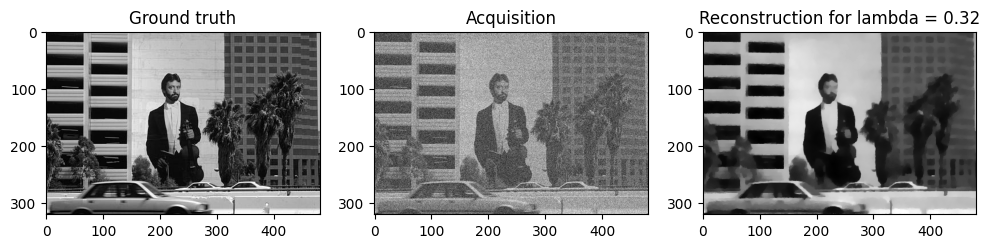

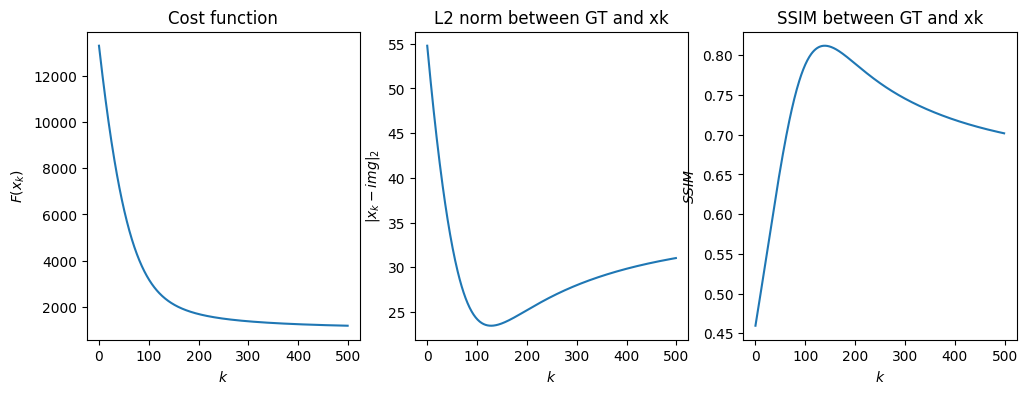

In [78]:
maxiter = 500
lmbda = 0.32
j = 0
filename = "ImagesOriginales/%s.jpg" %j
img = np.array(plt.imread(filename)/255, dtype="float64")
y = generateNoise(img,mode = "gaussian",seed = 43,clip = False,var = 0.02)
xk = y
xk, lmbda, cost, err, SSIMerr = GradientDescent(xk, lmbda, maxiter, y, img, early_stopping = False, stopping_threshold = 10e-6)
plotResults(img,y,xk,cost,err, SSIMerr, lmbda)

# The right iteration at which to stop the gradient descent is when the SSIM starts to decrease and not when the L2 norm starts to increase. As SSIM is a better estimation of the similarity.

#In this example we should stop at 139 iteration

In [79]:
for i in range(0,499):
  if err[i+1] > err[i]:
    break
for j in range(0,499):
  if SSIMerr[j+1] < SSIMerr[j]:
    break

print(i,j)

128 139


#We can try several values of lambda, we are gonna get similar behaviour without early stopping.

# The value taken into consideration are [0.1, 0.2 0.5 0.8 1.0]

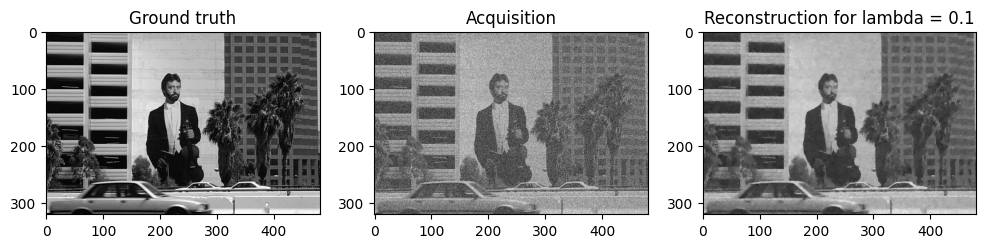

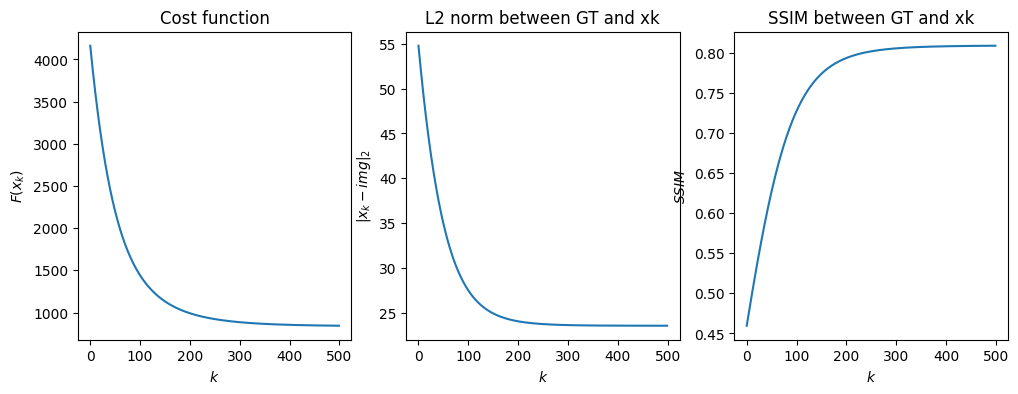

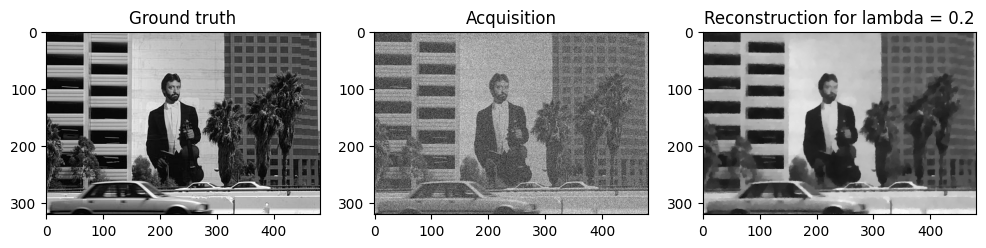

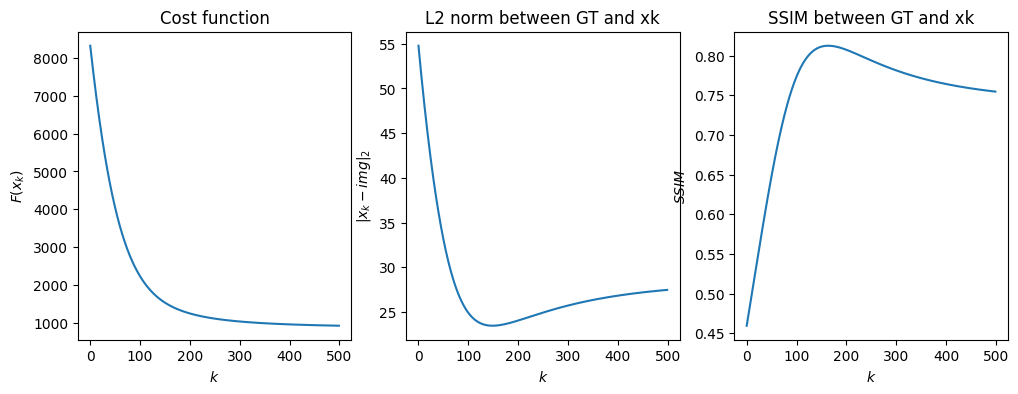

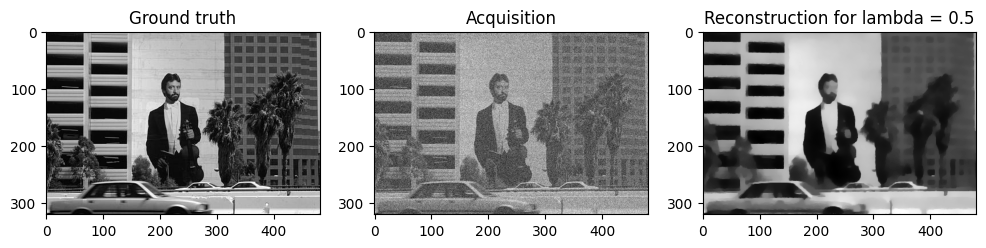

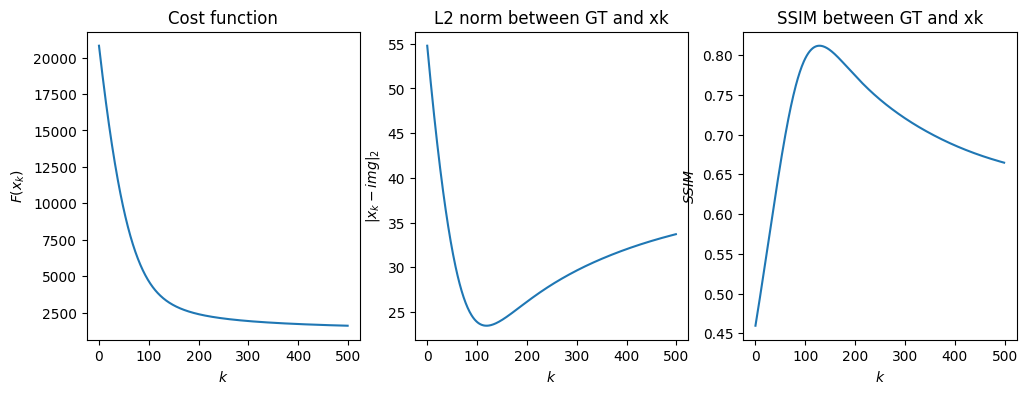

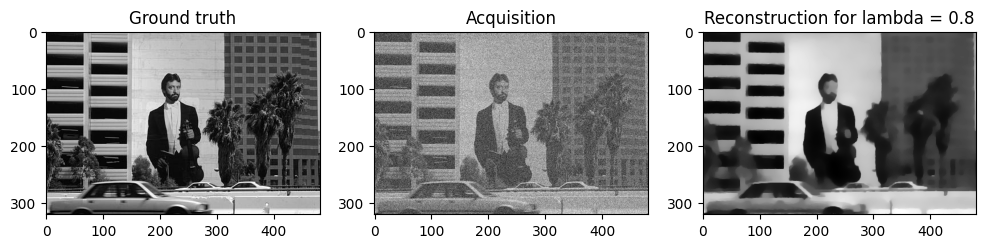

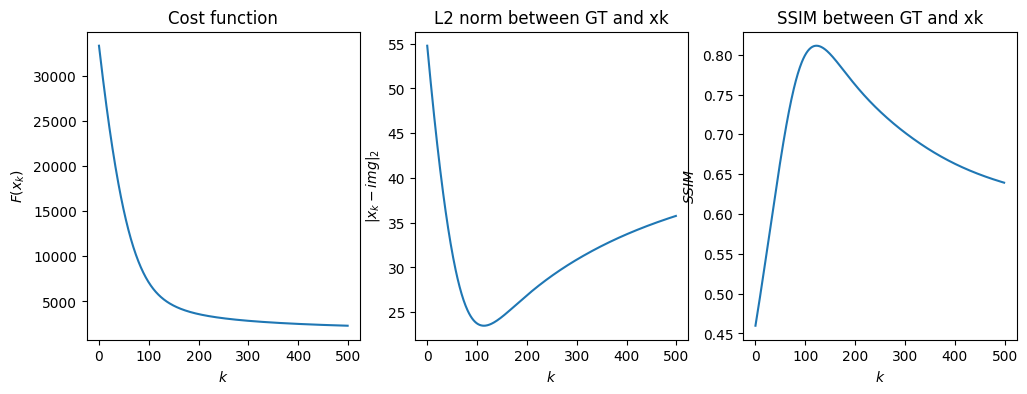

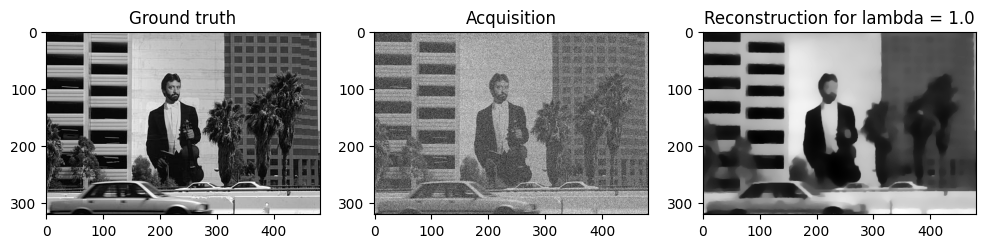

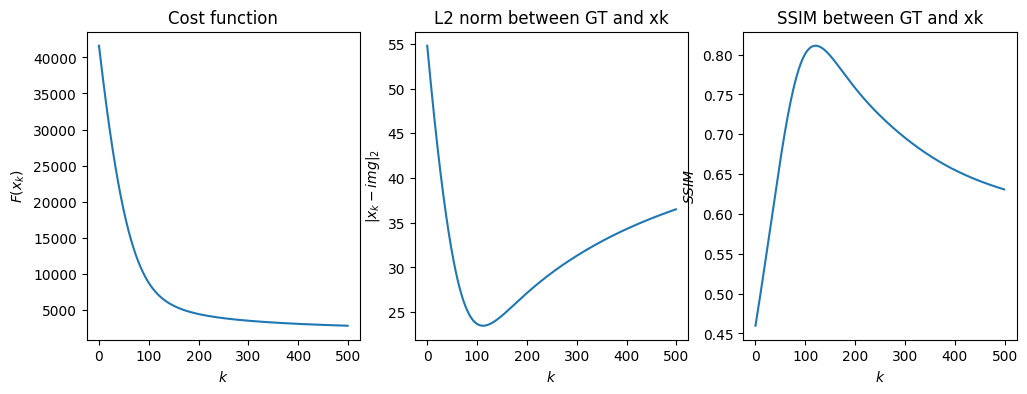

In [80]:
maxiter = 500
lmbda = [0.1,0.2,0.5,0.8,1.0]
j = 0
filename = "ImagesOriginales/%s.jpg" %j
img = np.array(plt.imread(filename)/255, dtype="float64")
y = generateNoise(img,mode = "gaussian",seed = 43,clip = False,var = 0.02)

for lmbdak in lmbda:
  xk = y
  xk, lmbda, cost, err, SSIMerr = GradientDescent(xk, lmbdak, maxiter, y, img, early_stopping = False, stopping_threshold = 10e-6)
  plotResults(img,y,xk,cost,err, SSIMerr, lmbdak)

-------------------------



#Now we try again the same cell of code, but with early_stopping setted as true. Just to see a "ideal" behaviour of our code and algorithm

I got stopped at iteration 129


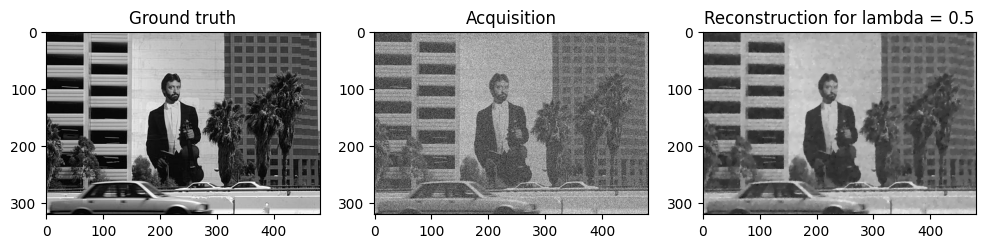

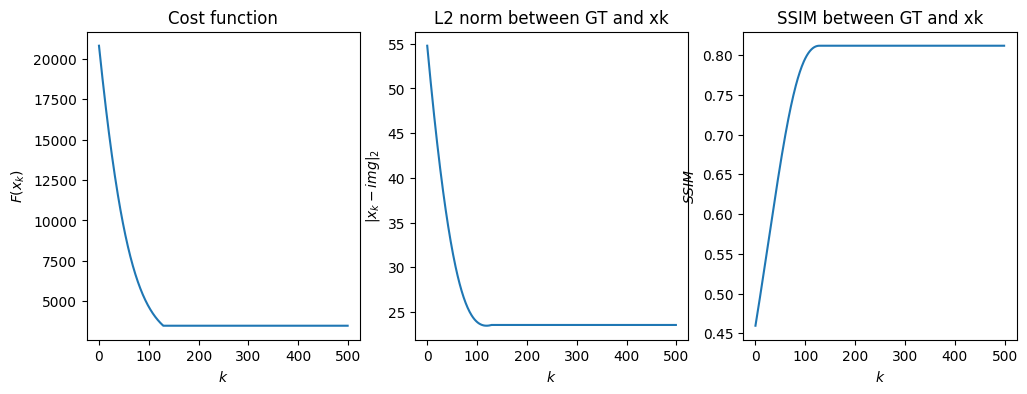

In [81]:
maxiter = 500
lmbda = 0.5
j = 0
filename = "ImagesOriginales/%s.jpg" %j
img = np.array(plt.imread(filename)/255, dtype="float64")
y = generateNoise(img,mode = "gaussian",seed = 43,clip = False,var = 0.02)
xk = y
xk, lmbda, cost, err, SSIMerr = GradientDescent(xk, lmbda, maxiter, y, img, early_stopping = True, stopping_threshold = 10e-6)
plotResults(img,y,xk,cost,err, SSIMerr, lmbda)

# Finding Lambda without brute force, but first with phase of exploration and then exploitation.
# We define lambda as an intermediate value (e.g. $\lambda = 0.5$ and then we define a range of four other value around)

# For example:
# We start with $\lambda =$ [0.2  0.35 0.5  0.65 0.8]
#We found that 0.2 is the optimal lambda, so we "exploit better" that range of values searching around 0.2 with $\lambda =$ [0.1  0.15 0.2  0.25 0.3 ].
#We found that 0.2 is the optimal lambda, and we exploit in a more fine-grained manner with $\lambda = $ [0.17  0.185 0.2   0.215 0.23 ]

# How do we find the optimal lambda in the range of values? We save the lambda as a key of a dictionary and the value of SSIM as a value. At the end, we extract the key with the highest value

In [82]:
alpha = [0.15, 0.05, 0.015]
lmbda = 0.5
maxiter = 500
j = 0
s = {}
filename = "ImagesOriginales/%s.jpg" %j
img = np.array(plt.imread(filename)/255, dtype="float64")
y = generateNoise(img,mode = "gaussian",seed = 43,clip = False,var = 0.02)

start = time.time()
for i in range(0,3):
  print("--------")
  print(f"range examined: {np.arange(start = lmbda - 2 * alpha[i], stop = lmbda + 2 * alpha[i] + 10e-5, step = alpha[i])}")
  for lmbdak in np.arange(start = lmbda - 2 * alpha[i], stop = lmbda + 2 * alpha[i] + 10e-5, step = alpha[i]):
    lmbdak = round(lmbdak,2) # overcoming weird numerical cancellation
    xk = y
    (xk,lmbdak, cost, err, SSIMerr) = GradientDescent(xk, lmbdak, maxiter, y, img)
    s[lmbdak] = SSIMerr[maxiter-1]
  lmbda = max(s.items(), key=operator.itemgetter(1))[0]
  print(s)
end = time.time()
print(f"computational time required {end - start} s and the optima lambda is {lmbda}")


--------
range examined: [0.2  0.35 0.5  0.65 0.8 ]
I got stopped at iteration 164
I got stopped at iteration 137
I got stopped at iteration 129
I got stopped at iteration 125
I got stopped at iteration 123
{0.2: 0.8123783437600657, 0.35: 0.8119952564509718, 0.5: 0.8117007024853866, 0.65: 0.811504518095156, 0.8: 0.8113604478049172}
--------
range examined: [0.1  0.15 0.2  0.25 0.3 ]
I got stopped at iteration 401
I got stopped at iteration 199
I got stopped at iteration 164
I got stopped at iteration 150
I got stopped at iteration 142
{0.2: 0.8123783437600657, 0.35: 0.8119952564509718, 0.5: 0.8117007024853866, 0.65: 0.811504518095156, 0.8: 0.8113604478049172, 0.1: 0.8082522981458015, 0.15: 0.812375954341713, 0.25: 0.8122542303545218, 0.3: 0.8121211914410823}
--------
range examined: [0.17  0.185 0.2   0.215 0.23 ]
I got stopped at iteration 180
I got stopped at iteration 174
I got stopped at iteration 164
I got stopped at iteration 160
I got stopped at iteration 154
{0.2: 0.81237834376

# Brute force

# Searching in the range [0,0.50]

In [83]:
start = time.time()
maxiter = 500
j = 0
s = {}
SSIMval = []
stopValue = 0.51

filename = "ImagesOriginales/%s.jpg" %j
img = np.array(plt.imread(filename)/255, dtype="float64")
y = generateNoise(img,mode = "gaussian",seed = 43,clip = False,var = 0.02)

for lmbdak in np.arange(0,stopValue,0.01):
  if(lmbdak % 0.1 == 0):
    print(f"Iteration {10* lmbdak / 0.1} / {10 * (stopValue - 0.01) / 0.1}")
  xk = y
  (xk, lmbdak, cost, err, SSIMerr) = GradientDescent(xk, lmbdak, maxiter, y, img)
  s[lmbdak] = SSIMerr[maxiter-1]
  SSIMval.append(SSIMerr[maxiter-1])
lmbda = max(s.items(), key=operator.itemgetter(1))[0]
end = time.time()
print(f"computational time required {end - start} s and the optima lambda is {lmbda}")

Iteration 0.0 / 50.0
I got stopped at iteration 1


<ipython-input-77-be218b66c09a>:40: RuntimeWarning: invalid value encountered in scalar divide
  if np.abs(cost[k] - cost[k-1]) / cost[k] < 20*stopping_threshold or (SSIMerr[k] - SSIMerr[k-1]) / SSIMerr[k] < stopping_threshold:


I got stopped at iteration 46
I got stopped at iteration 91
I got stopped at iteration 136
I got stopped at iteration 181
I got stopped at iteration 225
I got stopped at iteration 268
I got stopped at iteration 308
I got stopped at iteration 343
I got stopped at iteration 374
Iteration 10.0 / 50.0
I got stopped at iteration 401
I got stopped at iteration 344
I got stopped at iteration 274
I got stopped at iteration 237
I got stopped at iteration 214
I got stopped at iteration 199
I got stopped at iteration 188
I got stopped at iteration 180
I got stopped at iteration 174
I got stopped at iteration 168
Iteration 20.0 / 50.0
I got stopped at iteration 164
I got stopped at iteration 160
I got stopped at iteration 157
I got stopped at iteration 154
I got stopped at iteration 152
I got stopped at iteration 150
I got stopped at iteration 148
I got stopped at iteration 146
I got stopped at iteration 144
I got stopped at iteration 143
I got stopped at iteration 142
I got stopped at iteration 1

----------------------




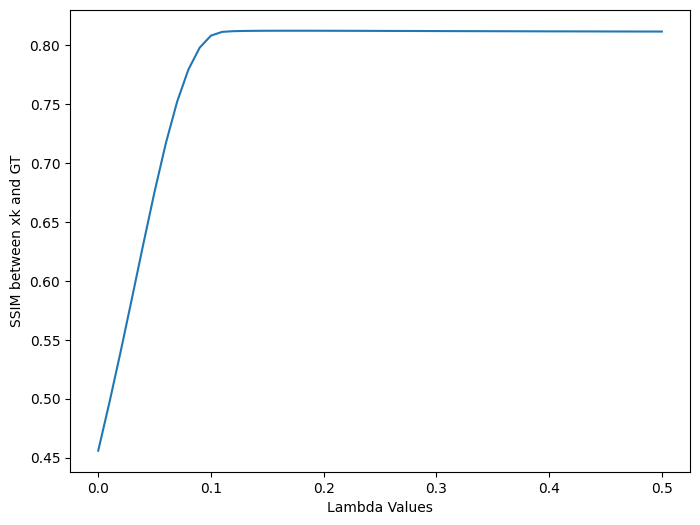

In [84]:
plt.figure(figsize = (8,6))
plt.plot(np.arange(0,0.51,0.01),SSIMval)
plt.xlabel('Lambda Values')
plt.ylabel('SSIM between xk and GT')
plt.show()

-------------------

---------------

#I did also a small change in the gradient descent algorithm. I normalize the sequence xk in the range [0,1] every iteration. It looks to give different results.

In [85]:
def NormalizedGradientDescent(x0, lmbda, maxiter, y, img, early_stopping = True, stopping_threshold = 10e-6):
  """
  Compute the minima of an optimization problem with a convex cost function

  PARAMETERS
  x0: (nd.array) initial sequence of the corrupted image
  lmbda: parameter of the regularization term
  maxiter: max of iteration of the algorithm
  y: corrupted image
  img: ground truth
  early stopping: True if we want a stopping criteria is active
  stopping_threshold: small value for the stopping criteria


  RETURN
  xk: final sequence of the corrupted image (after the denoising)
  lmbda: parameter of the regularization term
  cost: list of the values regarding the cost function
  err: list of L2 norms of xk - img
  SSIMerr: list of SSIM values between xk and img
  """
  xk = x0
  cost = np.zeros(maxiter)
  err = np.zeros(maxiter)
  SSIMerr = np.zeros(maxiter)
  (n1,n2) = np.shape(y)
  epsilon = 0.4*1e-2
  tau = 1.9 / (1 + lmbda * 8 / epsilon)
  for k in range(0,maxiter):
     repeatN = lambda x,k: resize( repeat( x, k, axis=1), [n1,n2,k])
     Gr = grad(xk) # Dx = (D^h x , D^v x)
     d = sqrt(epsilon**2 + sum(Gr**2, axis=2)) # ||Dx||_2 (with epsilon for smoothness)
     G = -div(Gr / repeatN(d,2) ) # -div (Dx / ||Dx||_2 )
     e = xk -y
     xk = xk - tau*(e + lmbda*G)
     xk = zeroOneScaling(xk)
     cost[k] = 0.5 * np.linalg.norm(e,2)**2 + lmbda * TV_norm(Gr)
     err[k] = np.linalg.norm(xk - img) #L2 norn
     SSIMerr[k] = skimage.metrics.structural_similarity(xk,img, data_range = 1)
     if early_stopping is True:
      if np.abs(cost[k] - cost[k-1]) / cost[k] < 20*stopping_threshold or (SSIMerr[k] - SSIMerr[k-1]) / SSIMerr[k] < stopping_threshold:
       cost[k:maxiter] = cost[k]
       err[k:maxiter] = err[k]
       SSIMerr[k:maxiter] = SSIMerr[k]
       print(f"I got stopped at iteration {k}")
       break

  return xk, lmbda, cost, err, SSIMerr

# We are gonna run the same algorithm (with normalization for every iteration) and the same range as before [0.1,0.2,0.5,0.8,1.0]

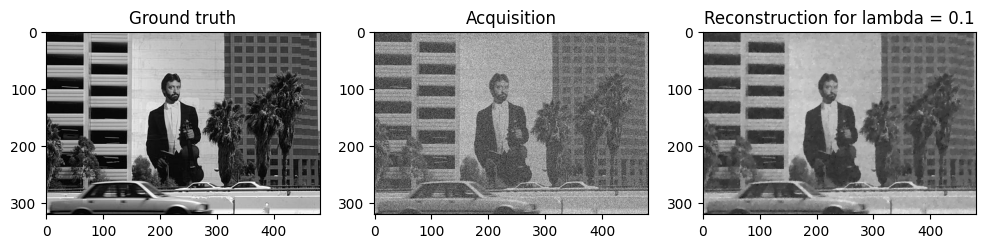

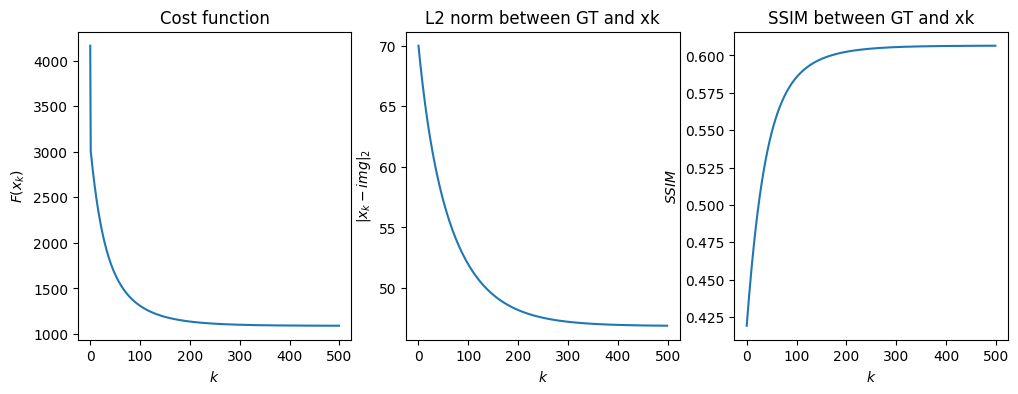

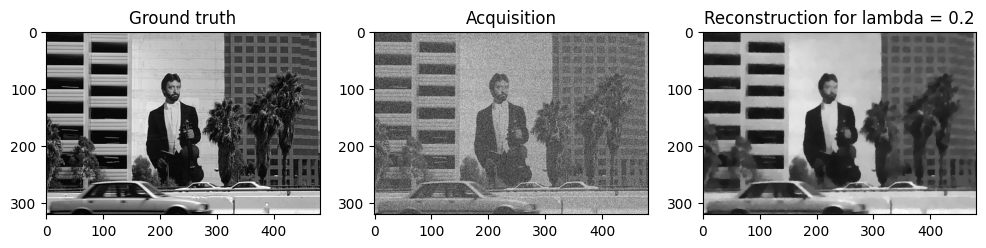

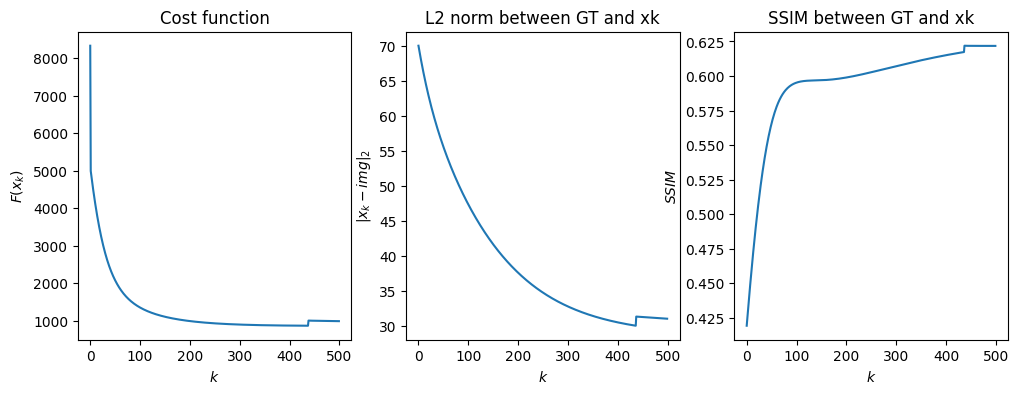

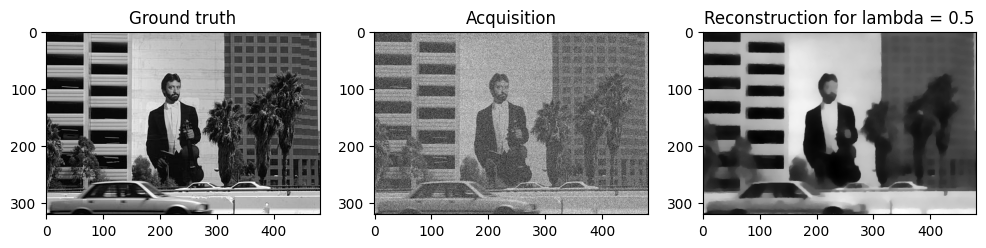

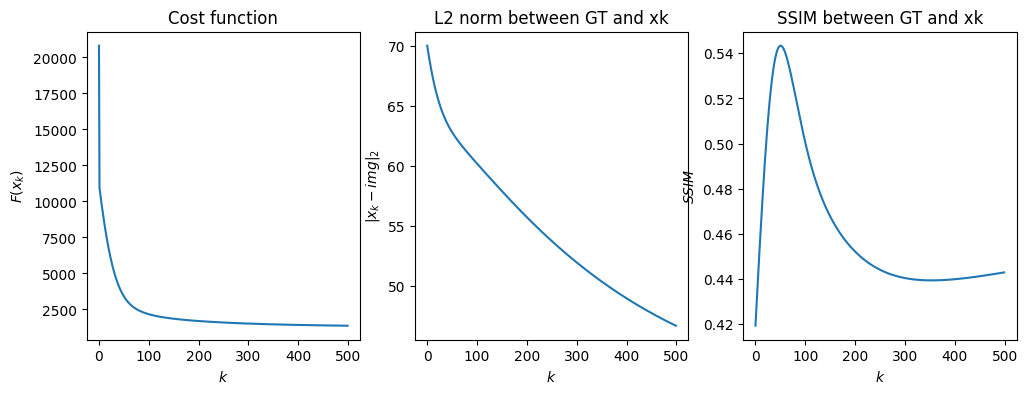

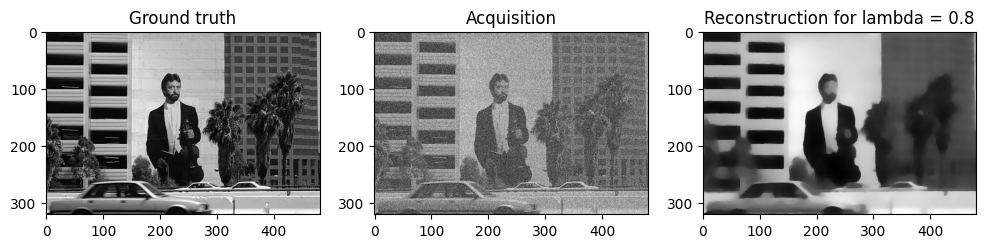

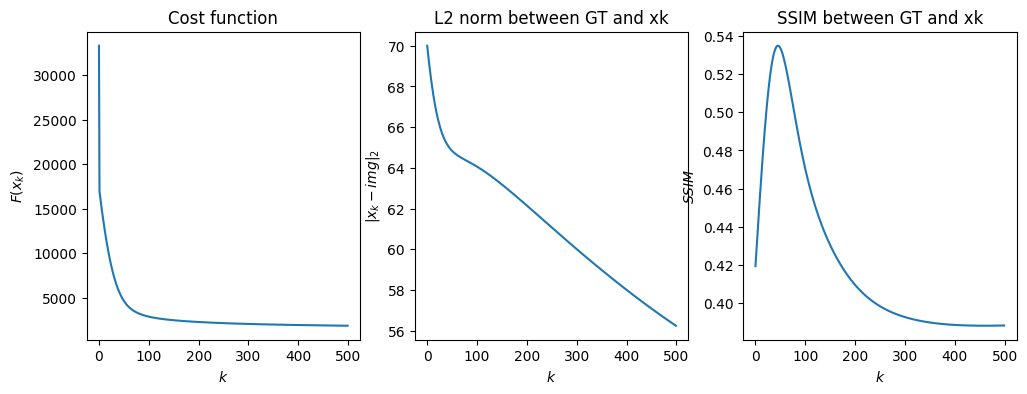

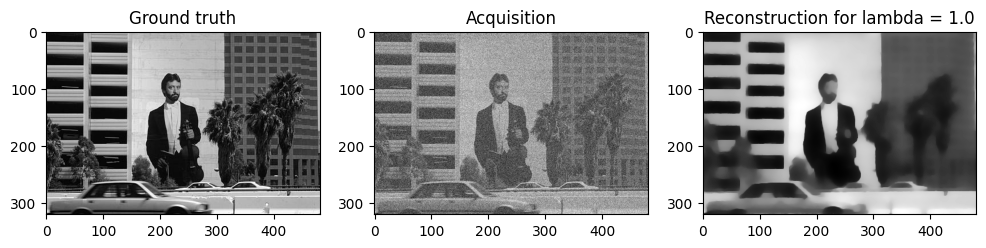

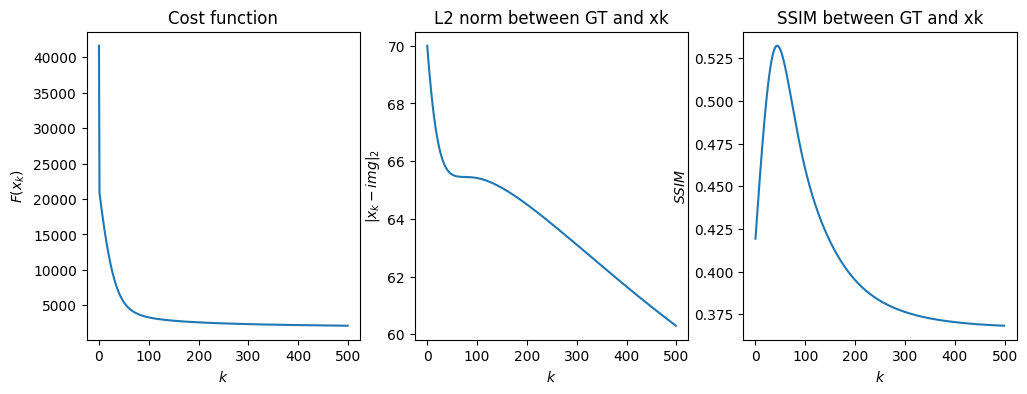

In [86]:
maxiter = 500
lmbda = [0.1,0.2,0.5,0.8,1.0]
j = 0
filename = "ImagesOriginales/%s.jpg" %j
img = np.array(plt.imread(filename)/255, dtype="float64")
y = generateNoise(img,mode = "gaussian",seed = 43,clip = False,var = 0.02)

for lmbdak in lmbda:
  xk = y
  xk, lmbda, cost, err, SSIMerr = NormalizedGradientDescent(xk, lmbdak, maxiter, y, img, early_stopping = False, stopping_threshold = 10e-6)
  plotResults(img,y,xk,cost,err, SSIMerr, lmbdak)

#Another run of brute force in range[0,0.50] with normalized gradient descent

In [87]:
start = time.time()
maxiter = 500
j = 0
s = {}
SSIMval = []
stopValue = 0.51

filename = "ImagesOriginales/%s.jpg" %j
img = np.array(plt.imread(filename)/255, dtype="float64")
y = generateNoise(img,mode = "gaussian",seed = 43,clip = False,var = 0.02)

for lmbdak in np.arange(0,stopValue,0.01):
  if(lmbdak % 0.1 == 0):
    print(f"Iteration {10* lmbdak / 0.1} / {10 * (stopValue - 0.01) / 0.1}")
  xk = y
  (xk, lmbdak, cost, err, SSIMerr) = GradientDescent(xk, lmbdak, maxiter, y, img)
  s[lmbdak] = SSIMerr[maxiter-1]
  SSIMval.append(SSIMerr[maxiter-1])
lmbda = max(s.items(), key=operator.itemgetter(1))[0]
end = time.time()
print(f"computational time required {end - start} s and the optima lambda is {lmbda}")

Iteration 0.0 / 50.0
I got stopped at iteration 1


<ipython-input-77-be218b66c09a>:40: RuntimeWarning: invalid value encountered in scalar divide
  if np.abs(cost[k] - cost[k-1]) / cost[k] < 20*stopping_threshold or (SSIMerr[k] - SSIMerr[k-1]) / SSIMerr[k] < stopping_threshold:


I got stopped at iteration 46
I got stopped at iteration 91
I got stopped at iteration 136
I got stopped at iteration 181
I got stopped at iteration 225
I got stopped at iteration 268
I got stopped at iteration 308
I got stopped at iteration 343
I got stopped at iteration 374
Iteration 10.0 / 50.0
I got stopped at iteration 401
I got stopped at iteration 344
I got stopped at iteration 274
I got stopped at iteration 237
I got stopped at iteration 214
I got stopped at iteration 199
I got stopped at iteration 188
I got stopped at iteration 180
I got stopped at iteration 174
I got stopped at iteration 168
Iteration 20.0 / 50.0
I got stopped at iteration 164
I got stopped at iteration 160
I got stopped at iteration 157
I got stopped at iteration 154
I got stopped at iteration 152
I got stopped at iteration 150
I got stopped at iteration 148
I got stopped at iteration 146
I got stopped at iteration 144
I got stopped at iteration 143
I got stopped at iteration 142
I got stopped at iteration 1

# Looks like that the optimal lambda can be anything between 0.15 and 0.5

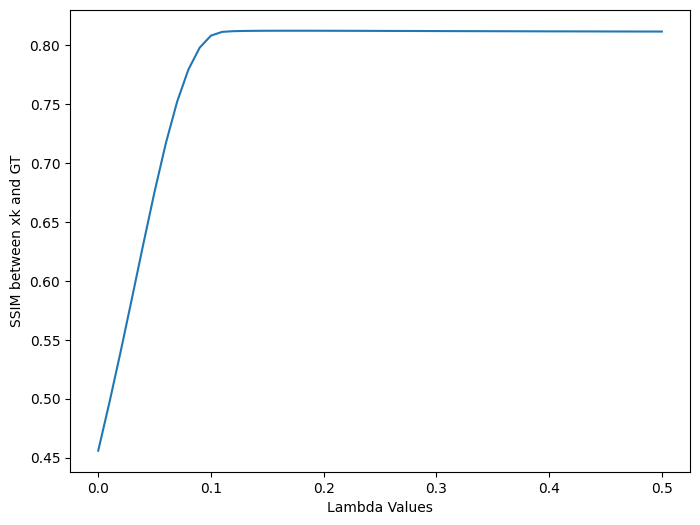

In [88]:
plt.figure(figsize = (8,6))
plt.plot(np.arange(0,0.51,0.01),SSIMval)
plt.xlabel('Lambda Values')
plt.ylabel('SSIM between xk and GT')
plt.show()

------------------

# #***Different normalization between 0 and 255***

In [93]:
def generateNoise(img, mode,seed,var,clip = False):
    ###
    # img : input image
    # mode : gaussian , poisson, speckle
    # seed : seed for the random generator
    # clip : True or False (clip the output in the range -1 , 1)
    # var : (variance for Gaussian and speckle mode)
    ###

    if mode == 'gaussian' or mode == 'speckle':
        gimg = skimage.util.random_noise(img, mode=mode,seed=seed,clip=clip,var=var)
        return gimg
    if mode == 'poisson':
      gimg = skimage.util.random_noise(img, mode=mode,seed=seed,clip=clip)
      return gimg

def TV_norm(gradX):
  ###
  # gradX : input tensor of shape (m,n,2)
  ###
  sum = 0
  (m,n,k) = np.shape(gradX)
  if(k != 2):
    print("The shape of GradX is not what was expected")
    raise exception
  sum = (np.sqrt(gradX[:,:,0]**2 + gradX[:,:,1]**2)).sum().sum()
  return sum

In [94]:
def GradientDescent(x0, lmbda, maxiter, y, img, early_stopping = True, stopping_threshold = 10e-6):
  """
  Compute the minima of an optimization problem with a convex cost function

  PARAMETERS
  x0: (nd.array) initial sequence of the corrupted image
  lmbda: parameter of the regularization term
  maxiter: max of iteration of the algorithm
  y: corrupted image
  img: ground truth
  early stopping: True if we want a stopping criteria is active
  stopping_threshold: small value for the stopping criteria


  RETURN
  xk: final sequence of the corrupted image (after the denoising)
  lmbda: parameter of the regularization term
  cost: list of the values regarding the cost function
  err: list of L2 norms of xk - img
  SSIMerr: list of SSIM values between xk and img
  """
  xk = x0
  cost = np.zeros(maxiter)
  err = np.zeros(maxiter)
  SSIMerr = np.zeros(maxiter)
  (n1,n2) = np.shape(y)
  epsilon = 0.4*1e-2
  tau = 1.9 / (1 + lmbda * 8 / epsilon)
  for k in range(0,maxiter):
     repeatN = lambda x,k: resize( repeat( x, k, axis=1), [n1,n2,k])
     Gr = grad(xk) # Dx = (D^h x , D^v x)
     d = sqrt(epsilon**2 + sum(Gr**2, axis=2)) # ||Dx||_2 (with epsilon for smoothness)
     G = -div(Gr / repeatN(d,2) ) # -div (Dx / ||Dx||_2 )
     e = xk -y
     xk = xk - tau*(e + lmbda*G)
     cost[k] = 0.5 * np.linalg.norm(e,2)**2 + lmbda * TV_norm(Gr)
     err[k] = np.linalg.norm(xk - img) #L2 norn
     SSIMerr[k] = skimage.metrics.structural_similarity(xk,img, data_range = 256)
     if early_stopping is True:
      if np.abs(cost[k] - cost[k-1]) / cost[k] < 20*stopping_threshold or (SSIMerr[k] - SSIMerr[k-1]) / SSIMerr[k] < stopping_threshold:
       cost[k:maxiter] = cost[k]
       err[k:maxiter] = err[k]
       SSIMerr[k:maxiter] = SSIMerr[k]
       print(f"I got stopped at iteration {k}")
       break

  return xk, lmbda, cost, err, SSIMerr

# Notice that we normalize our images into the range [0,255] only if an image has numbers greater than 255



In [95]:
"""
Notice that we normalize our images into the range [0,255] only if an image has numbers greater than 255
"""

def greyscaleScaling(img):
  ###
  # img : input image
  ###
  if(np.max(np.abs(img))) > 255:
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    img = img * 255
  return img

# Notice that the injection of the noise for the image range [0,255] is the $N \sim (\mu = 0,\sigma^{2} = 1296)$  because 0.02 for the range [0,1] is practically 1296 for [0,255]

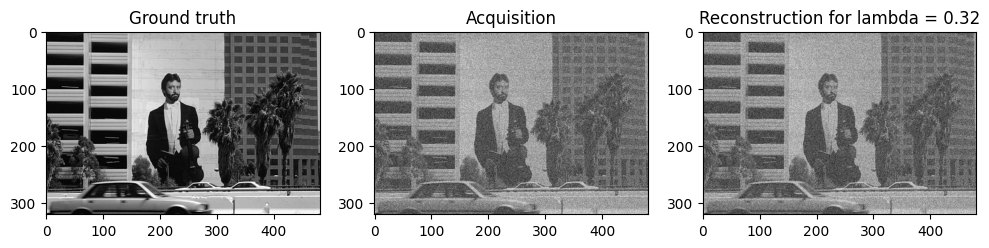

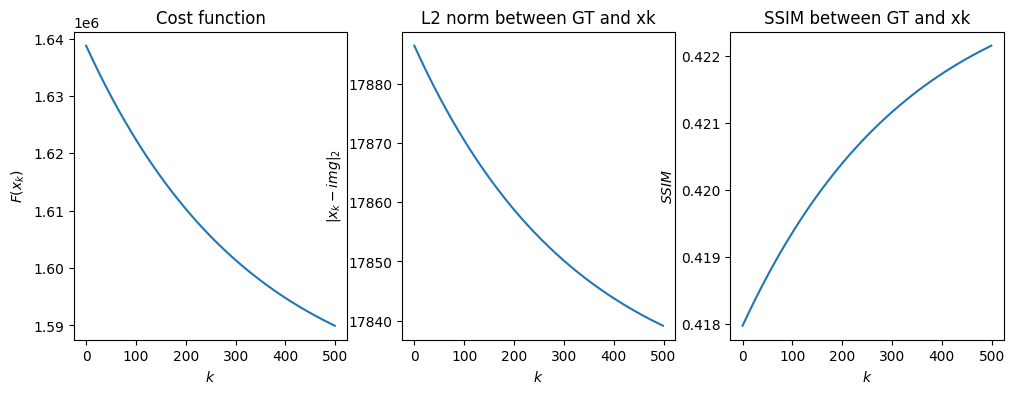

In [96]:
maxiter = 500
lmbda = 0.32
j = 0
filename = "ImagesOriginales/%s.jpg" %j


img = np.array(plt.imread(filename), dtype="float64")
y = generateNoise(img,mode = "gaussian",seed = 43,clip = False,var = 1296)
y = greyscaleScaling(y)

xk = y
xk, lmbda, cost, err, SSIMerr = GradientDescent(xk, lmbda, maxiter, y, img, early_stopping = False, stopping_threshold = 10e-6)
plotResults(img,y,xk,cost,err, SSIMerr, lmbda)



# As we can see the algorihm is not working properly, because the image is not getting denoised.
# One of the main reason is that the updating of the gradient descent:
# $x_k = x_k - \tau * (\frac{d}{dx} cost\_function)$
# The updating term is too little with respect to the range [0,255]


In [97]:
def ModifiedGradientDescent(x0, lmbda, maxiter, y, img, early_stopping = True, stopping_threshold = 10e-6):
  """
  Compute the minima of an optimization problem with a convex cost function

  PARAMETERS
  x0: (nd.array) initial sequence of the corrupted image
  lmbda: parameter of the regularization term
  maxiter: max of iteration of the algorithm
  y: corrupted image
  img: ground truth
  early stopping: True if we want a stopping criteria is active
  stopping_threshold: small value for the stopping criteria


  RETURN
  xk: final sequence of the corrupted image (after the denoising)
  lmbda: parameter of the regularization term
  cost: list of the values regarding the cost function
  err: list of L2 norms of xk - img
  SSIMerr: list of SSIM values between xk and img
  """
  xk = x0
  cost = np.zeros(maxiter)
  err = np.zeros(maxiter)
  SSIMerr = np.zeros(maxiter)
  gradientInfo = []
  (n1,n2) = np.shape(y)
  epsilon = 0.4*1e-2
  tau = 1.9 / (1 + lmbda * 8 / epsilon)
  for k in range(0,maxiter):
     repeatN = lambda x,k: resize( repeat( x, k, axis=1), [n1,n2,k])
     Gr = grad(xk) # Dx = (D^h x , D^v x)
     d = sqrt(epsilon**2 + sum(Gr**2, axis=2)) # ||Dx||_2 (with epsilon for smoothness)
     G = -div(Gr / repeatN(d,2) ) # -div (Dx / ||Dx||_2 )
     e = xk -y
     gradientInfo.append(tau*(e + lmbda*G))
     xk = xk - tau*(e + lmbda*G)
     cost[k] = 0.5 * np.linalg.norm(e,2)**2 + lmbda * TV_norm(Gr)
     err[k] = np.linalg.norm(xk - img) #L2 norn
     SSIMerr[k] = skimage.metrics.structural_similarity(xk,img, data_range = 256)
     if early_stopping is True:
      if np.abs(cost[k] - cost[k-1]) / cost[k] < 20*stopping_threshold or (SSIMerr[k] - SSIMerr[k-1]) / SSIMerr[k] < stopping_threshold:
       cost[k:maxiter] = cost[k]
       err[k:maxiter] = err[k]
       SSIMerr[k:maxiter] = SSIMerr[k]
       print(f"I got stopped at iteration {k}")
       break

  return xk, lmbda, cost, err, SSIMerr, gradientInfo

In [98]:
maxiter = 200
lmbda = 0.32
j = 0
filename = "ImagesOriginales/%s.jpg" %j


img = np.array(plt.imread(filename), dtype="float64")
y = generateNoise(img,mode = "gaussian",seed = 43,clip = False,var = 1296)
y = greyscaleScaling(y)

xk = y
xk, lmbda, cost, err, SSIMerr, gradientInfo = ModifiedGradientDescent(xk, lmbda, maxiter, y, img, early_stopping = False, stopping_threshold = 10e-6)

structs_array = []
for el in gradientInfo:
  tmpDict = {}
  tmp = el.flatten()
  tmpDict['infoMax'] = np.max(tmp)
  tmpDict['infoMin'] = np.min(tmp)
  tmpDict['infoMean'] = np.mean(tmp)
  tmpDict['infoStd'] = np.std(tmp)
  structs_array.append(tmpDict)
df = pd.DataFrame(structs_array)
df.head(20)

infoMax   infoMin      infoMean   infoStd
0   0.003237 -0.003238  5.392888e-22  0.001908
1   0.003228 -0.003228 -4.723271e-20  0.001902
2   0.003218 -0.003219 -8.048885e-20  0.001897
3   0.003209 -0.003209 -4.305322e-20  0.001891
4   0.003199 -0.003199  2.696444e-21  0.001885
5   0.003190 -0.003190 -7.639924e-22  0.001880
6   0.003180 -0.003181  1.123518e-21  0.001874
7   0.003171 -0.003171 -9.707198e-21  0.001868
8   0.003161 -0.003162 -3.559306e-20  0.001863
9   0.003152 -0.003152 -1.471809e-19  0.001857
10  0.003143 -0.003143 -1.669548e-19  0.001852
11  0.003133 -0.003134 -2.159402e-19  0.001846
12  0.003124 -0.003124 -2.119405e-19  0.001841
13  0.003115 -0.003115 -1.832234e-19  0.001835
14  0.003106 -0.003106 -2.133786e-19  0.001830
15  0.003096 -0.003097 -1.606182e-19  0.001824
16  0.003087 -0.003088 -1.445294e-19  0.001819
17  0.003078 -0.003078 -1.071387e-19  0.001813
18  0.003069 -0.003069 -7.235458e-20  0.001808
19  0.003060 -0.003060 -3.658176e-20  0.001802

# removed the old tau and we pass it by function

In [100]:
def ModifiedGradientDescent(x0, lmbda, maxiter, y, img, tau, early_stopping = True, stopping_threshold = 10e-6):
  """
  Compute the minima of an optimization problem with a convex cost function

  PARAMETERS
  x0: (nd.array) initial sequence of the corrupted image
  lmbda: parameter of the regularization term
  maxiter: max of iteration of the algorithm
  y: corrupted image
  img: ground truth
  early stopping: True if we want a stopping criteria is active
  stopping_threshold: small value for the stopping criteria


  RETURN
  xk: final sequence of the corrupted image (after the denoising)
  lmbda: parameter of the regularization term
  cost: list of the values regarding the cost function
  err: list of L2 norms of xk - img
  SSIMerr: list of SSIM values between xk and img
  """
  xk = x0
  cost = np.zeros(maxiter)
  err = np.zeros(maxiter)
  SSIMerr = np.zeros(maxiter)
  gradientInfo = []
  (n1,n2) = np.shape(y)
  epsilon = 0.4*1e-2
  #tau = 1.9 / (1 + lmbda * 8 / epsilon) removed the old tau and we pass it by function
  for k in range(0,maxiter):
     repeatN = lambda x,k: resize( repeat( x, k, axis=1), [n1,n2,k])
     Gr = grad(xk) # Dx = (D^h x , D^v x)
     d = sqrt(epsilon**2 + sum(Gr**2, axis=2)) # ||Dx||_2 (with epsilon for smoothness)
     G = -div(Gr / repeatN(d,2) ) # -div (Dx / ||Dx||_2 )
     e = xk -y
     gradientInfo.append(tau*(e + lmbda*G))
     xk = xk - tau*(e + lmbda*G)
     cost[k] = 0.5 * np.linalg.norm(e,2)**2 + lmbda * TV_norm(Gr)
     err[k] = np.linalg.norm(xk - img) #L2 norn
     SSIMerr[k] = skimage.metrics.structural_similarity(xk,img, data_range = 256)
     if early_stopping is True:
      if np.abs(cost[k] - cost[k-1]) / cost[k] < 20*stopping_threshold or (SSIMerr[k] - SSIMerr[k-1]) / SSIMerr[k] < stopping_threshold:
       cost[k:maxiter] = cost[k]
       err[k:maxiter] = err[k]
       SSIMerr[k:maxiter] = SSIMerr[k]
       print(f"I got stopped at iteration {k}")
       break

  return xk, lmbda, cost, err, SSIMerr, gradientInfo

# $\tau = 0.8 \; \; \lambda = 0.32$

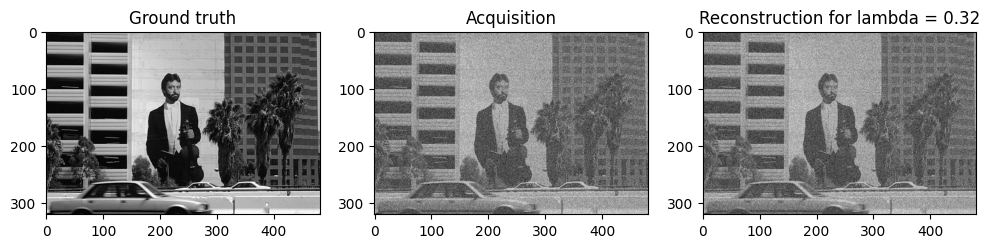

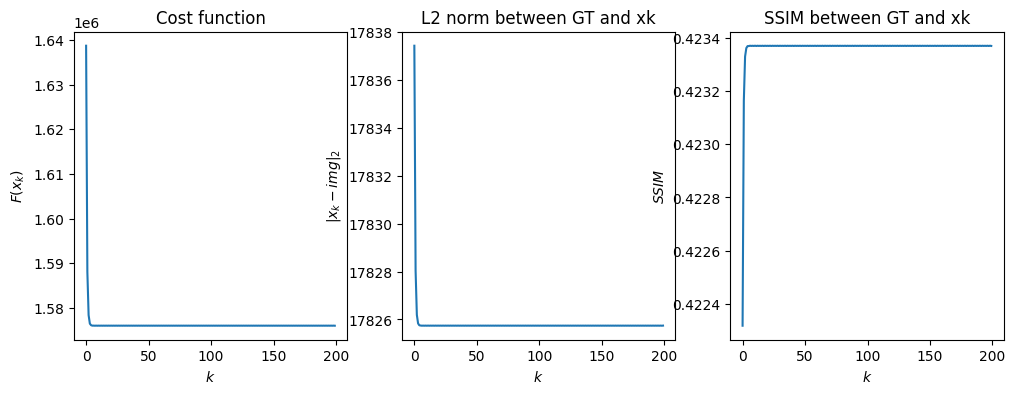

infoMax   infoMin      infoMean   infoStd
0   0.873766 -0.873834  5.752414e-20  0.514928
1   0.711346 -0.703411 -2.441900e-18  0.101230
2   0.624992 -0.686906  1.633685e-18  0.025085
3   0.684634 -0.615224  2.368359e-17  0.017109
4   0.613243 -0.685573 -8.533391e-18  0.016468
5   0.693842 -0.686720 -1.791967e-17  0.016582
6   0.612591 -0.692944 -1.049609e-17  0.016680
7   0.692105 -0.612551 -2.608450e-18  0.016682
8   0.612560 -0.692125  6.957994e-18  0.016811
9   0.692156 -0.612558  8.935026e-18  0.016770
10  0.612558 -0.692155  1.175515e-18  0.016700
11  0.692153 -0.688462 -1.826077e-17  0.016851
12  0.612558 -0.692153 -1.882399e-17  0.016802
13  0.692153 -0.612558  4.004545e-18  0.016704
14  0.612558 -0.692153  5.820049e-18  0.016848
15  0.692153 -0.612558 -1.700387e-17  0.016815
16  0.612558 -0.692153 -1.525199e-17  0.016717
17  0.692153 -0.688505 -1.798303e-17  0.016852
18  0.612558 -0.692153  7.674978e-18  0.016817
19  0.692153 -0.612558  7.311498e-18  0.016725

In [101]:
maxiter = 200
lmbda = 0.32
j = 0
filename = "ImagesOriginales/%s.jpg" %j
tau = 0.8

img = np.array(plt.imread(filename), dtype="float64")
y = generateNoise(img,mode = "gaussian",seed = 43,clip = False,var = 1296)
y = greyscaleScaling(y)

xk = y
xk, lmbda, cost, err, SSIMerr, gradientInfo = ModifiedGradientDescent(xk, lmbda, maxiter, y, img, tau, early_stopping = False, stopping_threshold = 10e-6)
plotResults(img,y,xk,cost,err, SSIMerr, lmbda)


structs_array = []
for el in gradientInfo:
  tmpDict = {}
  tmp = el.flatten()
  tmpDict['infoMax'] = np.max(tmp)
  tmpDict['infoMin'] = np.min(tmp)
  tmpDict['infoMean'] = np.mean(tmp)
  tmpDict['infoStd'] = np.std(tmp)
  structs_array.append(tmpDict)
df = pd.DataFrame(structs_array)
df.head(20)

# $\tau = 2 \; \; \lambda = 0.32$

# The values of infoMax and infoMin of the cost function's derivative became comparable with the range [0,255] but also too large

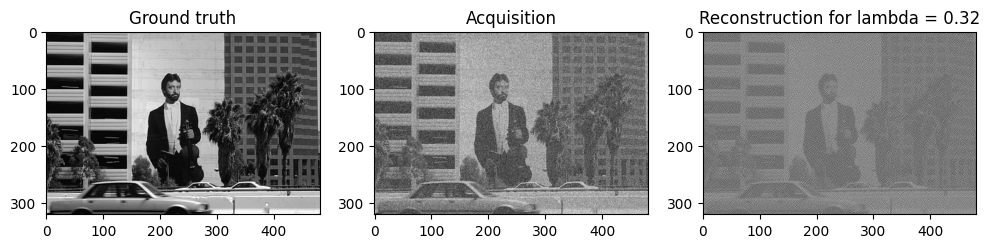

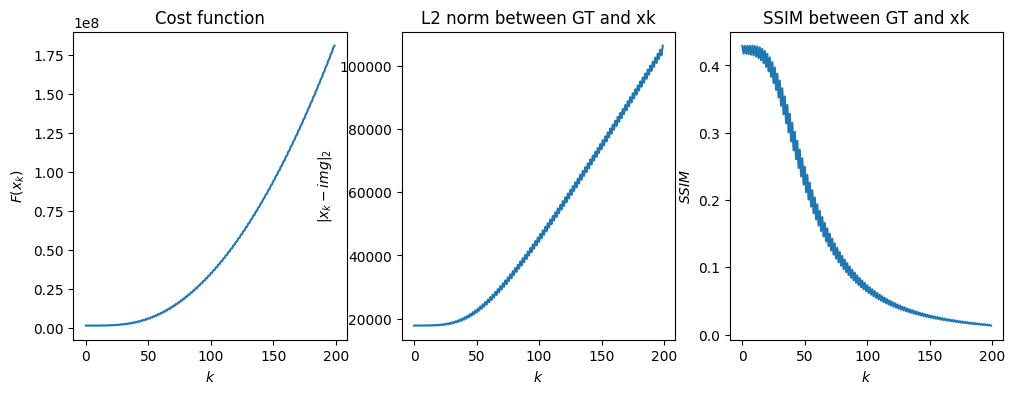

infoMax    infoMin      infoMean    infoStd
0    2.184415  -2.184585  4.601931e-19   1.287320
1    4.051358  -4.883500 -9.618036e-18   1.326176
2    7.653676  -6.691677  8.881727e-18   1.387098
3    9.934979 -10.624305 -2.478140e-17   1.490391
4   13.661001 -13.290103 -1.265531e-17   1.633778
5   16.994749 -17.714183 -1.113667e-17   1.840407
6   21.778721 -20.785238  1.339162e-17   2.096251
7   24.997291 -25.843263 -2.982051e-17   2.425083
8   29.904733 -29.237206  1.007823e-17   2.803351
9   33.464699 -33.956161 -1.286240e-17   3.257047
10  38.000980 -37.701324  3.032672e-17   3.757506
11  41.923087 -42.034585 -2.439023e-17   4.333176
12  46.060849 -46.145206  6.564654e-17   4.953446
13  50.351446 -50.076491 -7.280255e-17   5.649012
14  54.244928 -54.552758  8.034971e-17   6.388023
15  58.739429 -58.395075 -6.764838e-17   7.202625
16  62.537503 -62.919548  1.136677e-16   8.060161
17  67.086303 -66.660608 -1.225954e-16   8.993194
18  70.774639 -71.245646  7.841690e-17   9.968767
19  75.392330 -74.869788 -6.332257e-17  11.018855

In [102]:
maxiter = 200
lmbda = 0.32
j = 0
filename = "ImagesOriginales/%s.jpg" %j
tau = 2

img = np.array(plt.imread(filename), dtype="float64")
y = generateNoise(img,mode = "gaussian",seed = 43,clip = False,var = 1296)
y = greyscaleScaling(y)

xk = y
xk, lmbda, cost, err, SSIMerr, gradientInfo = ModifiedGradientDescent(xk, lmbda, maxiter, y, img, tau, early_stopping = False, stopping_threshold = 10e-6)
plotResults(img,y,xk,cost,err, SSIMerr, lmbda)


structs_array = []
for el in gradientInfo:
  tmpDict = {}
  tmp = el.flatten()
  tmpDict['infoMax'] = np.max(tmp)
  tmpDict['infoMin'] = np.min(tmp)
  tmpDict['infoMean'] = np.mean(tmp)
  tmpDict['infoStd'] = np.std(tmp)
  structs_array.append(tmpDict)
df = pd.DataFrame(structs_array)
df.head(20)

# $\tau = 0.8 \; \; \lambda = 5$


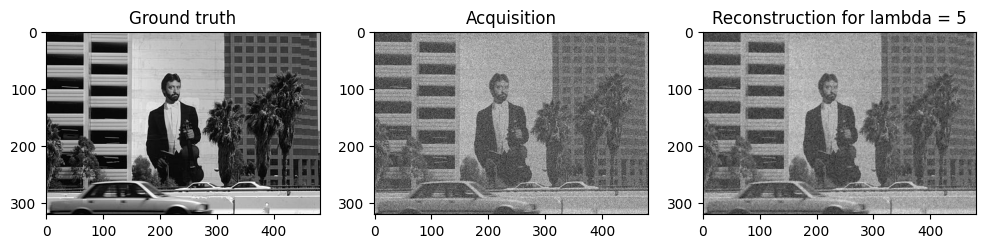

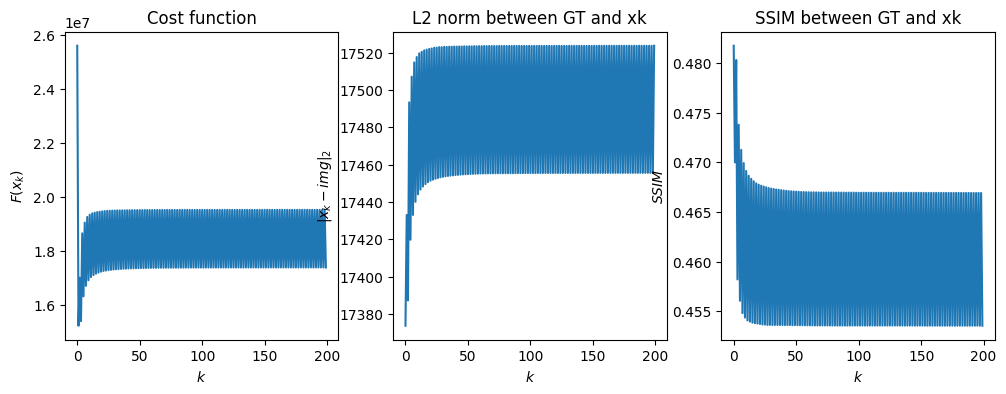

infoMax    infoMin      infoMean   infoStd
0   13.652594 -13.653659 -1.288541e-18  8.045749
1   24.049523 -24.203396 -4.049699e-18  5.689260
2   23.380773 -23.472485 -1.707316e-17  6.935182
3   22.978961 -22.844373  2.830188e-18  8.182189
4   22.944211 -22.475378  4.786008e-18  8.642351
5   22.368678 -22.487975  2.346985e-18  8.867892
6   22.218633 -22.366501 -2.208927e-18  9.059982
7   22.093393 -22.739172 -1.274735e-17  9.177965
8   22.079136 -22.101003 -6.350665e-18  9.272003
9   22.109556 -22.446744 -3.635525e-18  9.321522
10  22.125161 -22.110368  1.274735e-17  9.375160
11  22.114549 -22.151376 -5.890472e-18  9.406790
12  22.142850 -22.114379 -1.210308e-17  9.439692
13  22.116496 -22.153976  7.823283e-19  9.456866
14  22.150944 -22.116295  7.040954e-18  9.480129
15  22.313639 -22.174071  1.472618e-18  9.494711
16  22.224376 -22.268541  1.380579e-19  9.513153
17  22.441401 -22.158243  7.823283e-18  9.522667
18  22.157994 -22.393494 -1.003221e-17  9.536424
19  22.444492 -22.457294 -1.615278e-17  9.544964

In [103]:
maxiter = 200
lmbda = 5
j = 0
filename = "ImagesOriginales/%s.jpg" %j
tau = 0.8

img = np.array(plt.imread(filename), dtype="float64")
y = generateNoise(img,mode = "gaussian",seed = 43,clip = False,var = 1296)
y = greyscaleScaling(y)

xk = y
xk, lmbda, cost, err, SSIMerr, gradientInfo = ModifiedGradientDescent(xk, lmbda, maxiter, y, img, tau, early_stopping = False, stopping_threshold = 10e-6)
plotResults(img,y,xk,cost,err, SSIMerr, lmbda)


structs_array = []
for el in gradientInfo:
  tmpDict = {}
  tmp = el.flatten()
  tmpDict['infoMax'] = np.max(tmp)
  tmpDict['infoMin'] = np.min(tmp)
  tmpDict['infoMean'] = np.mean(tmp)
  tmpDict['infoStd'] = np.std(tmp)
  structs_array.append(tmpDict)
df = pd.DataFrame(structs_array)
df.head(20)

# $\tau = 1.5 \; \; \lambda = 10$

# The values of the cost function's derivate became too large as you can see from the table of infoMax, infoMin

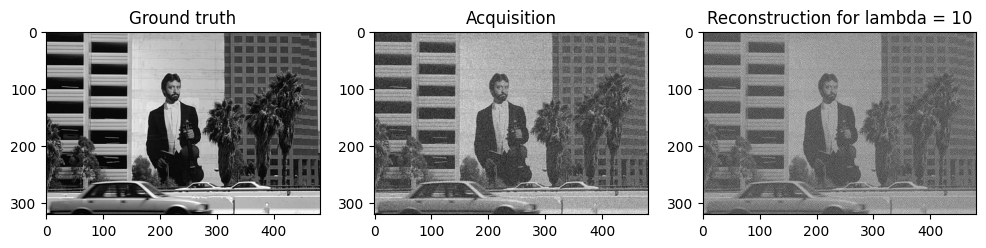

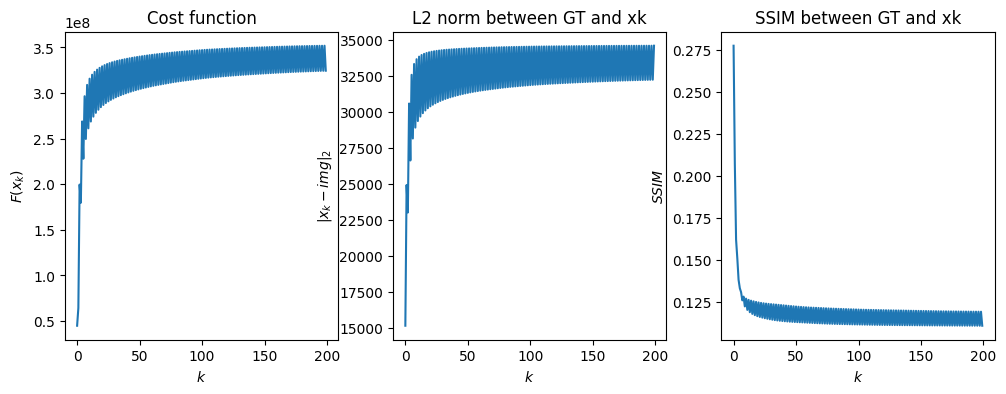

infoMax     infoMin      infoMean     infoStd
0    51.208358  -51.201189 -9.572016e-18   29.427100
1   127.514734 -127.963223  7.657613e-17   74.221717
2   166.264103 -165.629351  1.914403e-17  102.908335
3   184.948538 -185.296007  8.835707e-18  119.758556
4   194.617349 -194.590587  6.332257e-17  130.073042
5   199.408901 -199.478018  6.774042e-17  136.102039
6   202.046964 -201.901612  1.236999e-16  140.095941
7   202.913853 -203.232650 -6.774042e-17  142.524861
8   203.923785 -203.661939 -3.387021e-17  144.360445
9   204.031794 -204.289018  1.001380e-16  145.541680
10  204.479645 -204.328336  8.099398e-18  146.576982
11  204.492541 -204.576221  4.859639e-17  147.275525
12  204.624165 -204.573926  4.123330e-17  147.956275
13  204.589730 -204.643556 -6.332257e-17  148.426797
14  204.646215 -204.586108 -3.239759e-17  148.924387
15  204.548385 -204.637489  1.958582e-16  149.276469
16  204.620513 -204.510549 -8.541184e-17  149.668182
17  204.446383 -204.597114  1.325356e-17  149.947859
18  204.582347 -204.388575 -3.092498e-17  150.268505
19  204.366623 -204.534778  7.768059e-17  150.497983

In [108]:
maxiter = 200
lmbda = 10
j = 0
filename = "ImagesOriginales/%s.jpg" %j
tau = 1.5

img = np.array(plt.imread(filename), dtype="float64")
y = generateNoise(img,mode = "gaussian",seed = 43,clip = False,var = 1296)
y = greyscaleScaling(y)

xk = y
xk, lmbda, cost, err, SSIMerr, gradientInfo = ModifiedGradientDescent(xk, lmbda, maxiter, y, img, tau, early_stopping = False, stopping_threshold = 10e-6)
plotResults(img,y,xk,cost,err, SSIMerr, lmbda)


structs_array = []
for el in gradientInfo:
  tmpDict = {}
  tmp = el.flatten()
  tmpDict['infoMax'] = np.max(tmp)
  tmpDict['infoMin'] = np.min(tmp)
  tmpDict['infoMean'] = np.mean(tmp)
  tmpDict['infoStd'] = np.std(tmp)
  structs_array.append(tmpDict)
df = pd.DataFrame(structs_array)
df.head(20)

# I also tried to clip the image between 0 and 255 after each iteration, but do not have a great utility

In [104]:
def ModifiedGradientDescent(x0, lmbda, maxiter, y, img, tau, early_stopping = True, stopping_threshold = 10e-6):
  """
  Compute the minima of an optimization problem with a convex cost function

  PARAMETERS
  x0: (nd.array) initial sequence of the corrupted image
  lmbda: parameter of the regularization term
  maxiter: max of iteration of the algorithm
  y: corrupted image
  img: ground truth
  early stopping: True if we want a stopping criteria is active
  stopping_threshold: small value for the stopping criteria


  RETURN
  xk: final sequence of the corrupted image (after the denoising)
  lmbda: parameter of the regularization term
  cost: list of the values regarding the cost function
  err: list of L2 norms of xk - img
  SSIMerr: list of SSIM values between xk and img
  """
  xk = x0
  cost = np.zeros(maxiter)
  err = np.zeros(maxiter)
  SSIMerr = np.zeros(maxiter)
  gradientInfo = []
  (n1,n2) = np.shape(y)
  epsilon = 0.4*1e-2
  #tau = 1.9 / (1 + lmbda * 8 / epsilon) removed the old tau and we pass it by function
  for k in range(0,maxiter):
     repeatN = lambda x,k: resize( repeat( x, k, axis=1), [n1,n2,k])
     Gr = grad(xk) # Dx = (D^h x , D^v x)
     d = sqrt(epsilon**2 + sum(Gr**2, axis=2)) # ||Dx||_2 (with epsilon for smoothness)
     G = -div(Gr / repeatN(d,2) ) # -div (Dx / ||Dx||_2 )
     e = xk -y
     gradientInfo.append(tau*(e + lmbda*G))
     xk = xk - tau*(e + lmbda*G)
     cost[k] = 0.5 * np.linalg.norm(e,2)**2 + lmbda * TV_norm(Gr)
     err[k] = np.linalg.norm(xk - img) #L2 norn
     SSIMerr[k] = skimage.metrics.structural_similarity(xk,img, data_range = 256)
     xk = greyscaleScaling(xk) # ADDED
     if early_stopping is True:
      if np.abs(cost[k] - cost[k-1]) / cost[k] < 20*stopping_threshold or (SSIMerr[k] - SSIMerr[k-1]) / SSIMerr[k] < stopping_threshold:
       cost[k:maxiter] = cost[k]
       err[k:maxiter] = err[k]
       SSIMerr[k:maxiter] = SSIMerr[k]
       print(f"I got stopped at iteration {k}")
       break

  return xk, lmbda, cost, err, SSIMerr, gradientInfo

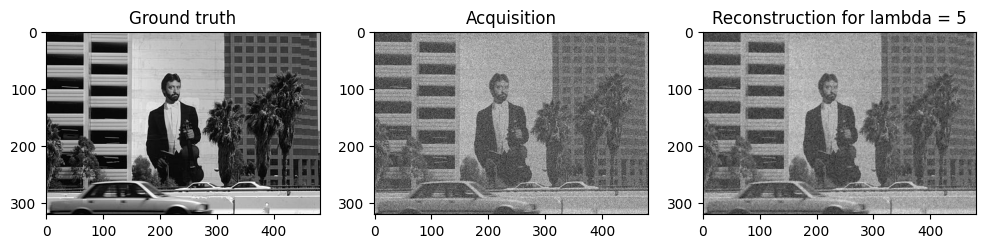

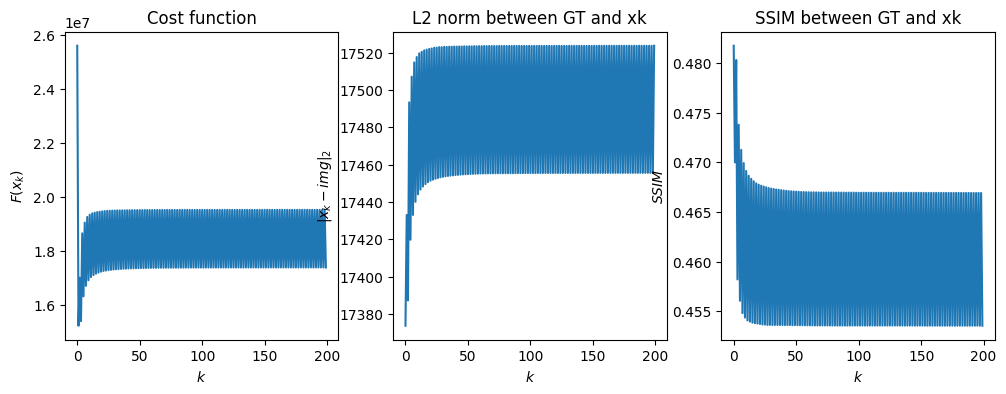

infoMax    infoMin      infoMean   infoStd
0   13.652594 -13.653659 -1.288541e-18  8.045749
1   24.049523 -24.203396 -4.049699e-18  5.689260
2   23.380773 -23.472485 -1.707316e-17  6.935182
3   22.978961 -22.844373  2.830188e-18  8.182189
4   22.944211 -22.475378  4.786008e-18  8.642351
5   22.368678 -22.487975  2.346985e-18  8.867892
6   22.218633 -22.366501 -2.208927e-18  9.059982
7   22.093393 -22.739172 -1.274735e-17  9.177965
8   22.079136 -22.101003 -6.350665e-18  9.272003
9   22.109556 -22.446744 -3.635525e-18  9.321522
10  22.125161 -22.110368  1.274735e-17  9.375160
11  22.114549 -22.151376 -5.890472e-18  9.406790
12  22.142850 -22.114379 -1.210308e-17  9.439692
13  22.116496 -22.153976  7.823283e-19  9.456866
14  22.150944 -22.116295  7.040954e-18  9.480129
15  22.313639 -22.174071  1.472618e-18  9.494711
16  22.224376 -22.268541  1.380579e-19  9.513153
17  22.441401 -22.158243  7.823283e-18  9.522667
18  22.157994 -22.393494 -1.003221e-17  9.536424
19  22.444492 -22.457294 -1.615278e-17  9.544964

In [105]:
maxiter = 200
lmbda = 5
j = 0
filename = "ImagesOriginales/%s.jpg" %j
tau = 0.8

img = np.array(plt.imread(filename), dtype="float64")
y = generateNoise(img,mode = "gaussian",seed = 43,clip = False,var = 1296)
y = greyscaleScaling(y)

xk = y
xk, lmbda, cost, err, SSIMerr, gradientInfo = ModifiedGradientDescent(xk, lmbda, maxiter, y, img, tau, early_stopping = False, stopping_threshold = 10e-6)
plotResults(img,y,xk,cost,err, SSIMerr, lmbda)


structs_array = []
for el in gradientInfo:
  tmpDict = {}
  tmp = el.flatten()
  tmpDict['infoMax'] = np.max(tmp)
  tmpDict['infoMin'] = np.min(tmp)
  tmpDict['infoMean'] = np.mean(tmp)
  tmpDict['infoStd'] = np.std(tmp)
  structs_array.append(tmpDict)
df = pd.DataFrame(structs_array)
df.head(20)

# The only solution indeed is to change both $\lambda$ and $\tau$ with higher values. Even thought I can't understand why the value of SSIM remains so low. One reason may be that the skimage library is not working as intended

In [106]:
def ModifiedGradientDescent(x0, lmbda, maxiter, y, img, tau, early_stopping = True, stopping_threshold = 10e-6):
  """
  Compute the minima of an optimization problem with a convex cost function

  PARAMETERS
  x0: (nd.array) initial sequence of the corrupted image
  lmbda: parameter of the regularization term
  maxiter: max of iteration of the algorithm
  y: corrupted image
  img: ground truth
  early stopping: True if we want a stopping criteria is active
  stopping_threshold: small value for the stopping criteria


  RETURN
  xk: final sequence of the corrupted image (after the denoising)
  lmbda: parameter of the regularization term
  cost: list of the values regarding the cost function
  err: list of L2 norms of xk - img
  SSIMerr: list of SSIM values between xk and img
  """
  xk = x0
  cost = np.zeros(maxiter)
  err = np.zeros(maxiter)
  SSIMerr = np.zeros(maxiter)
  gradientInfo = []
  (n1,n2) = np.shape(y)
  epsilon = 0.4*1e-2
  #tau = 1.9 / (1 + lmbda * 8 / epsilon) removed the old tau and we pass it by function
  for k in range(0,maxiter):
     repeatN = lambda x,k: resize( repeat( x, k, axis=1), [n1,n2,k])
     Gr = grad(xk) # Dx = (D^h x , D^v x)
     d = sqrt(epsilon**2 + sum(Gr**2, axis=2)) # ||Dx||_2 (with epsilon for smoothness)
     G = -div(Gr / repeatN(d,2) ) # -div (Dx / ||Dx||_2 )
     e = xk -y
     gradientInfo.append(tau*(e + lmbda*G))
     xk = xk - tau*(e + lmbda*G)
     cost[k] = 0.5 * np.linalg.norm(e,2)**2 + lmbda * TV_norm(Gr)
     err[k] = np.linalg.norm(xk - img) #L2 norn
     SSIMerr[k] = skimage.metrics.structural_similarity(xk,img, data_range = 256)
     if early_stopping is True:
      if np.abs(cost[k] - cost[k-1]) / cost[k] < 20*stopping_threshold or (SSIMerr[k] - SSIMerr[k-1]) / SSIMerr[k] < stopping_threshold:
       cost[k:maxiter] = cost[k]
       err[k:maxiter] = err[k]
       SSIMerr[k:maxiter] = SSIMerr[k]
       print(f"I got stopped at iteration {k}")
       break

  return xk, lmbda, cost, err, SSIMerr, gradientInfo

I got stopped at iteration 63


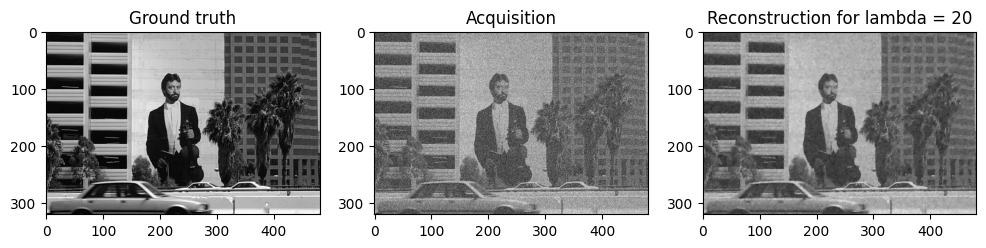

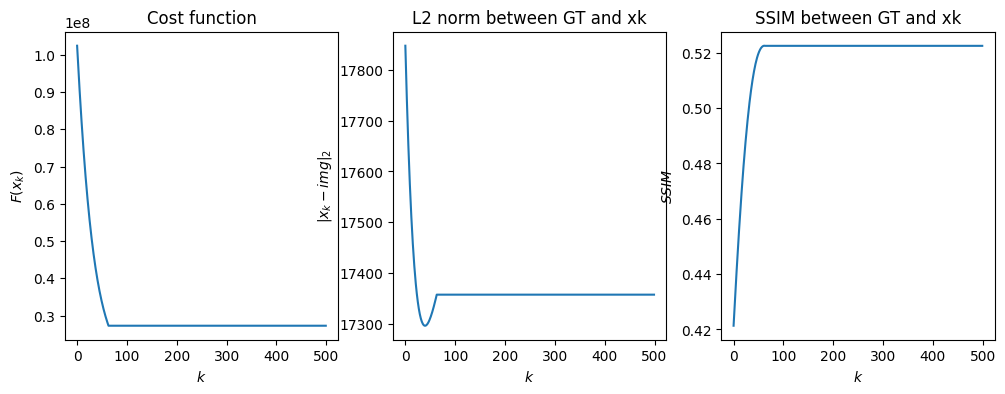

infoMax   infoMin      infoMean   infoStd
0   0.682630 -0.682683 -6.902896e-20  0.402287
1   0.675868 -0.675838 -3.451448e-20  0.396108
2   0.669136 -0.669001 -1.150483e-20  0.389855
3   0.662420 -0.662300 -6.902896e-20  0.383562
4   0.655751 -0.659346  1.955821e-19  0.377244
5   0.652572 -0.649208 -2.300965e-20  0.370956
6   0.649608 -0.651753 -1.840772e-19  0.364616
7   0.646783 -0.636381 -1.380579e-19  0.358343
8   0.642609 -0.663609 -4.947076e-19  0.352084
9   0.633730 -0.643490 -1.725724e-19  0.345894
10  0.644228 -0.637282 -1.495628e-19  0.339783
11  0.649825 -0.636607  1.380579e-19  0.333666
12  0.631854 -0.648143 -2.416014e-19  0.327649
13  0.665539 -0.621789 -1.840772e-19  0.321699
14  0.628129 -0.640289  1.150483e-19  0.315838
15  0.695511 -0.671135 -4.601931e-19  0.310076
16  0.650022 -0.635223  1.150483e-20  0.304448
17  0.685361 -0.643827  2.300965e-19  0.298758
18  0.687910 -0.645205  4.141738e-19  0.293281
19  0.650667 -0.675860  4.716979e-19  0.288103

In [107]:
maxiter = 500
lmbda = 20
j = 0
filename = "ImagesOriginales/%s.jpg" %j
tau = 0.01

img = np.array(plt.imread(filename), dtype="float64")
y = generateNoise(img,mode = "gaussian",seed = 43,clip = False,var = 1296)
y = greyscaleScaling(y)

xk = y
xk, lmbda, cost, err, SSIMerr, gradientInfo = ModifiedGradientDescent(xk, lmbda, maxiter, y, img, tau, early_stopping = True, stopping_threshold = 10e-6)
plotResults(img,y,xk,cost,err, SSIMerr, lmbda)


structs_array = []
for el in gradientInfo:
  tmpDict = {}
  tmp = el.flatten()
  tmpDict['infoMax'] = np.max(tmp)
  tmpDict['infoMin'] = np.min(tmp)
  tmpDict['infoMean'] = np.mean(tmp)
  tmpDict['infoStd'] = np.std(tmp)
  structs_array.append(tmpDict)
df = pd.DataFrame(structs_array)
df.head(20)